In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [193]:
data = pd.read_csv('survey_data_cleaned.csv')
data.head()

,Timestamp,Which apartment building do you/have you lived in? (ie: Skyloft),What school year did you live there?,What was your monthly rent amount?,How many bedrooms were in your apartment?,Was your apartment double occupant?,How many bathrooms were in your apartment?,Please select the below that applied to your apartment,"On a scale of 1 (horrible) to 5 (great), how was your overall experience at the building?",Year Built
0,27:47.0,Croix,2022-2023,1800.00,2,No,2,"Includes a parking lot, Unfurnished, No gym, N...",2,1982
1,28:13.0,Skyloft,2022-2023,1100.00,3,No,3,NaN,4,2018
2,28:20.0,Croix,2021-2022,1650.00,2,No,2,"Includes a parking lot, No gym, No pool",2,1982
3,29:44.3,Skyloft,2022-2023,1050.00,3,No,3,NaN,4,2018
4,30:13.2,Ion,2021-2022,1000.00,3,No,3,No window,1,2017


In [194]:
set(data['What school year did you live there?'].values)
data['year_num'] = data['What school year did you live there?'].astype('category').cat.codes

# Create a rent column that is twice as much if apartment is double occupancy
data['Rent'] = data['What was your monthly rent amount?']
data.loc[data['Was your apartment double occupant?'] == 'Yes', 'Rent'] = data['Rent'] * 2

options = ['Includes a parking lot', 'No window', 'No gym', 'No pool', 'Unfurnished']

# create a new column for each option and set the values to True or False
for option in options:
    data[option] = data['Please select the below that applied to your apartment'].str.contains(option)

# Fill missing values with False
data = data.fillna(False)

In [195]:
data.drop(columns=['Timestamp', 'What school year did you live there?', 'Was your apartment double occupant?', 'Please select the below that applied to your apartment', 'What was your monthly rent amount?'], inplace=True)
column_mapping = {'Which apartment building do you/have you lived in? (ie: Skyloft)': 'apt_building',
                  'How many bedrooms were in your apartment?': 'num_beds',
                  'How many bathrooms were in your apartment?': 'num_baths',
                  'On a scale of 1 (horrible) to 5 (great), how was your overall experience at the building?': 'overall_rating',
                  'Was your apartment double occupant?': 'double_occupancy'}
data = data.rename(columns=column_mapping)
data

,apt_building,num_beds,num_baths,overall_rating,Year Built,year_num,Rent,Includes a parking lot,No window,No gym,No pool,Unfurnished
0,Croix,2,2,2,1982,4,1800.00,True,False,True,True,True
1,Skyloft,3,3,4,2018,4,1100.00,False,False,False,False,False
2,Croix,2,2,2,1982,3,1650.00,True,False,True,True,False
3,Skyloft,3,3,4,2018,4,1050.00,False,False,False,False,False
4,Ion,3,3,1,2017,3,1000.00,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
132,Torre,3,3,4,2021,4,1820.00,True,False,False,False,False
133,Block on Rio,4,4,3,0,2,950.00,True,False,True,True,False
134,Regents West on 26th,2,1,5,2012,4,1080.00,True,False,False,True,False
135,2215,4,4,2,2016,4,1200.00,False,False,False,True,False


In [196]:
import json

with open('apt_distance.json') as f:
    apt_dists = json.load(f)

# Convert dict values to float
apt_dists = {k: float(v) for k, v in apt_dists.items()}

# Add apt_dists to the dataframe
data['apt_dists'] = data['apt_building'].map(apt_dists)
data['apt_building'] = data['apt_building'].astype('category')
apt_building_mapping = dict(enumerate(data['apt_building'].cat.categories))
data['apt_building'] = data['apt_building'].cat.codes
# data['apt_building'] = data['apt_building'].cat.codesdata.dropna(subset=['apt_dists'], inplace=True)

In [197]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Rent'])
y = data['Rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=3)

model = xgb.XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train, verbose=False)

preds = model.predict(X_test)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, preds)

print('R^2:', r2)

R^2: 0.8540502671057356


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

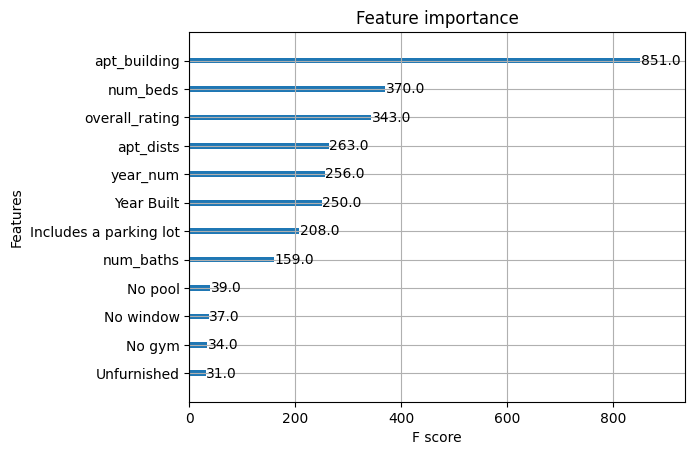

In [198]:
# Plot most important features
xgb.plot_importance(model)

In [206]:
# # Predict the rent price
# y_pred = model.predict(X_test)

# # Plot the predicted vs actual rent price
# plt.scatter(y_test, y_pred)
# plt.xlabel("Actual Rent Price")
# plt.ylabel("Predicted Rent Price")
# plt.title("Predicted vs Actual Rent Price")

# Calculating residuals
residuals = y_test - preds

# # Calculating value scores using Min-Max scaling on residuals
# min_residual = np.min(residuals)
# max_residual = np.max(residuals)

# value_scores = 100 * (residuals - min_residual) / (max_residual - min_residual)

# # First, converting the value_scores (which is a numpy array) to a pandas Series
# value_scores_series = pd.Series(value_scores, index=X_test.index, name='Value_Score')
# value_scores_series = 100 - value_scores_series

# Calculating value scores using z-score scaling
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)

value_scores = 100 * (residuals - mean_residual) / std_residual

# Ensure value scores are between 0 and 100
value_scores = np.maximum(0, np.minimum(100, value_scores))

# First, converting the value_scores (which is a numpy array) to a pandas Series
value_scores_series = 100 - pd.Series(value_scores, index=X_test.index, name='Value_Score')

preds = pd.Series(preds, index=X_test.index, name='Predicted_Rent')

# Now, concatenate the X_test DataFrame with the value_scores_series
result_df = pd.concat([X_test, value_scores_series, y_test, preds], axis=1)

# merge on index to get the columns from `data`
# result_df = data.merge(result_df, left_index=True, right_index=True)

# # If you only want specific columns from `data`, for instance 'column1', 'column2', you can do:
# selected_columns = data.loc[result_df.index]

# # Now, concatenate the y_test with the selected columns
# result_df = pd.concat([result_df, selected_columns], axis=1)
result_df['apt_building'] = result_df['apt_building'].map(apt_building_mapping)
# Display the resulting DataFrame
result_df.sort_values(by='Value_Score', ascending=False)

,apt_building,num_beds,num_baths,overall_rating,Year Built,year_num,Includes a parking lot,No window,No gym,No pool,Unfurnished,apt_dists,Value_Score,Rent,Predicted_Rent
41,Quarters Grayson House,4,4,4,2008,3,True,False,False,False,False,0.50,100.00,750.00,1037.55
76,Villas on Nueces,3,3,5,2019,4,True,False,False,False,False,0.40,100.00,1200.00,1349.87
115,Legacy on Rio,5,4,3,2021,4,True,False,False,True,False,0.70,100.00,1000.00,1139.45
38,Axis West Campus,4,4,3,2012,4,False,False,False,False,False,0.90,100.00,975.00,1075.08
111,2400 Nueces,1,1,4,2012,4,True,False,False,False,False,0.40,100.00,1550.00,1666.52
53,Villas on Rio,2,2,5,2021,4,True,False,False,False,False,0.40,100.00,1458.00,2096.04
5,Lark,4,4,5,2019,3,False,False,False,False,False,0.40,100.00,1000.00,1067.64
8,Yugo Austin Nueces,4,2,3,2018,3,False,True,False,False,False,NaN,100.00,1035.00,1202.19
125,Villas on Rio,2,2,2,2021,4,True,False,False,False,False,0.40,100.00,1520.00,2173.76
77,Quarters Nueces House,2,2,4,2008,3,False,False,False,False,True,0.40,100.00,1000.00,1179.02


In [200]:
# # # Use the factorize function to automatically map strings to numbers
# data['apt_building'] = data['apt_building'].astype('category')
# apt_building_mapping = dict(enumerate(data['apt_building'].cat.categories))
# data['apt_building'] = data['apt_building'].cat.codes
# # data['apt_building'] = data['apt_building'].map(apt_building_mapping)
# data